In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [5]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [9]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [12]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [13]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['station', 'measurement']

In [14]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station


In [15]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [16]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

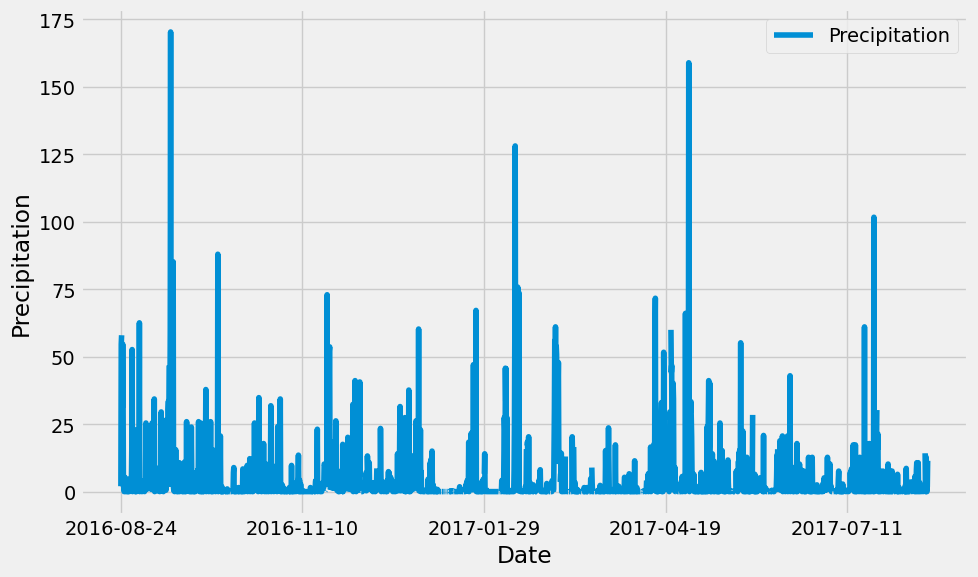

In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
import pandas as pd
from datetime import datetime, timedelta

# Calculate the date one year from the last date in data set.
one_year_ago = datetime.strptime(most_recent_date, "%Y-%m-%d") - timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
precipitation_data = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= one_year_ago)
    .order_by(Measurement.date)
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=["Date", "Precipitation"])
precipitation_df.set_index("Date", inplace=True)

# Sort the dataframe by date
precipitation_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.tight_layout()
plt.show()

In [22]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df.describe()
precipitation_summary

,Precipitation
count,2015.000000
mean,4.485112
std,11.690532
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [23]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.station).count()
total_stations

9

In [25]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
conn = engine.connect()
active_stations = pd.read_sql(
    conn
).set_index("Station")

# Display the DataFrame
active_stations

,Count
Station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [26]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = active_stations.index[0] 
temperature_stats = pd.read_sql(
    f"""
    SELECT 
        MIN(tobs) AS Lowest_Temperature,
        MAX(tobs) AS Highest_Temperature,
        AVG(tobs) AS Average_Temperature
    FROM measurement
    WHERE station = '{most_active_station_id}'
    """,
    conn
)
temperature_stats

,Lowest_Temperature,Highest_Temperature,Average_Temperature
0,12.2,29.4,22.035823


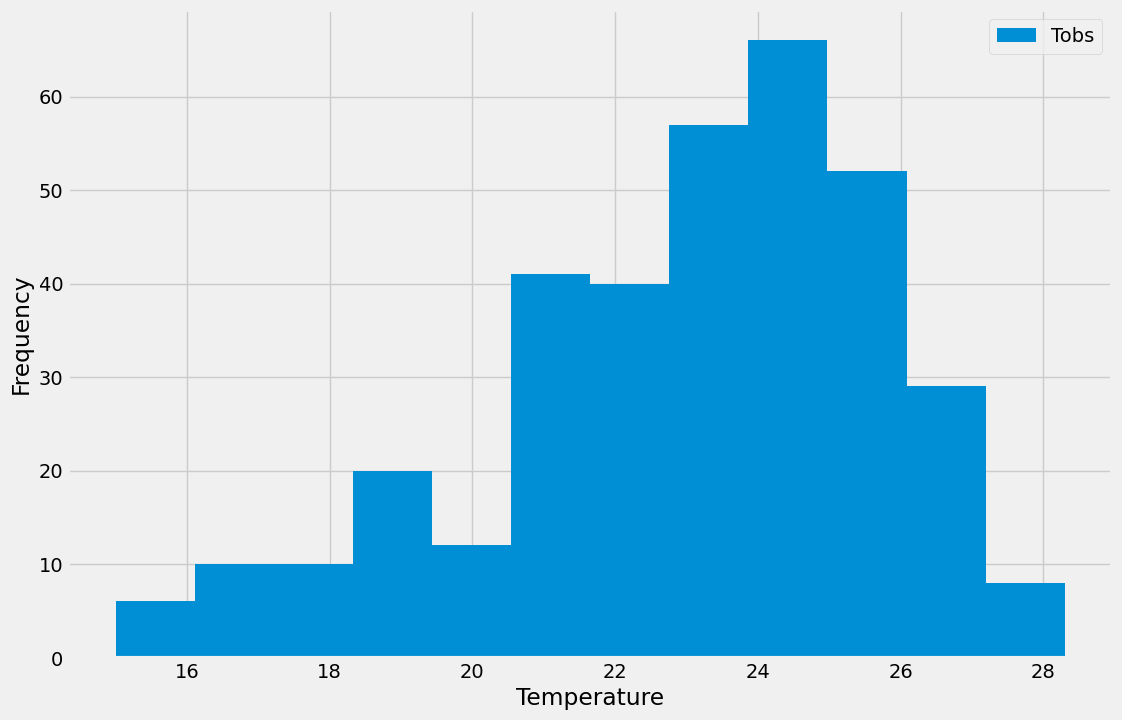

In [37]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
one_year_ago = datetime.strptime(most_recent_date, "%Y-%m-%d") - timedelta(days=365)
most_active_station_id = active_stations.index[0]
temperature_data = pd.read_sql(
    f"""
    SELECT tobs AS Tobs
    FROM measurement
    WHERE station = '{most_active_station_id}'
    AND date >= '{one_year_ago}'
    """,
    conn
)

temperature_data.plot(kind="hist", bins=12, figsize=(12, 8),)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [38]:
# Close Session
session.close()
